<a href="https://colab.research.google.com/github/varunk04/computer_vision/blob/main/05_Transfer_Learning(Feature_Extractoion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working models existing architecture and learned patterns for own problems

There are two main benefits :

1. Can leverage an existing Neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to own data.

In [1]:
# are we using the GPU?
!nvidia-smi

Mon May 22 13:46:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading the data:

In [2]:
# Get data (10% of 10 food classes from Food101 dataset):

import zipfile

# Download the data:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file:
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-05-22 13:50:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.5MB/s    in 4.6s    

2023-05-22 13:50:09 (35.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder:

import os

# Walk through the directory:

for dirpath, dirnames ,filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 2 directories and 0 images in '10_food_classes_10_percent
There are 10 directories and 0 images in '10_food_classes_10_percent/test
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream
There are 

## Create data loaders (preparing data):

We will use ImageDataGenerator class to load in our images in batches.

In [7]:
import tensorflow as tf

In [5]:
# Setup the data:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_shape = (224,224)
Batch_size = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training images:')
train_data_10 = train_datagen.flow_from_directory(train_dir,
                                                  target_size = Image_shape,
                                                  batch_size = Batch_size,
                                                  class_mode = 'categorical'
                                                  )
test_data_10 = train_datagen.flow_from_directory(test_dir,
                                                  target_size = Image_shape,
                                                  batch_size = Batch_size,
                                                  class_mode = 'categorical'
                                                  )

Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up the callbacks (Thinghs to run whilst our model trains):

callbacks are extra functinality you can add to your models to be performed during or after training. Some of the commonly used callbacks are :

* Tracking experiments with the Tensorflow callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback.

In [9]:
# Create a tensorboard callback function:
import datetime

def tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S%')
  tensorboard_call = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving tensorboard log files to: {log_dir}')
  return tensorboard_call

## Creating models using Tensorflow hub:

In [10]:
# Lets compare following 2 models:

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficient_net_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [11]:
# Import dependencies:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [13]:
# Lets make a fucntion to create a model form a URL:
def create_model(model_url, num_classes = 10):
  '''
  Takes a Tensorflow Hub URL and creates a keras Sequential model with it
  '''
  # Download the pretained model:
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = Image_shape+(3,))
  #create our own model:
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model

### Creating  and testing ResNet model:

In [14]:
# Create the resnet:

resnet_model = create_model(resnet_url,
                            num_classes=train_data_10.num_classes)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
# Compile our resnet model:

resnet_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [18]:
# Fitting resnet model:

restnet_history = resnet_model.fit(train_data_10,
                                   epochs = 5,
                                   steps_per_epoch = len(train_data_10),
                                   validation_data = test_data_10,
                                   validation_steps =len(test_data_10),
                                   callbacks = [tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                     experiment_name = 'ResNet50')
                                                                     ])

Saving tensorboard log files to: tensorflow_hub/ResNet50/20230522-162127%
Epoch 1/5
24/24 [==============================] - 35s 891ms/step - loss: 1.9856 - accuracy: 0.3600 - val_loss: 1.2634 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 18s 790ms/step - loss: 0.9172 - accuracy: 0.7507 - val_loss: 0.8676 - val_accuracy: 0.7320
Epoch 3/5
24/24 [==============================] - 18s 771ms/step - loss: 0.6224 - accuracy: 0.8307 - val_loss: 0.7548 - val_accuracy: 0.7676
Epoch 4/5
24/24 [==============================] - 19s 803ms/step - loss: 0.4845 - accuracy: 0.8707 - val_loss: 0.7139 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 18s 783ms/step - loss: 0.3797 - accuracy: 0.9227 - val_loss: 0.6823 - val_accuracy: 0.7796


* With just few lines of code and with just 10 % data we were able to get an validation accurcay nearing to 80%.

* Thats the power of feature extraction tranfer learning.


In [19]:
import matplotlib.pyplot as plt

In [20]:
def loss_curve(history):
  """
  Return the training and testing/validation loss

  Args :
  history : Tensorflow history object

  returns:
  plots of training /validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss:
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy:
  plt.figure()
  plt.plot(epochs, accuracy, label = 'Training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'validation_accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend();

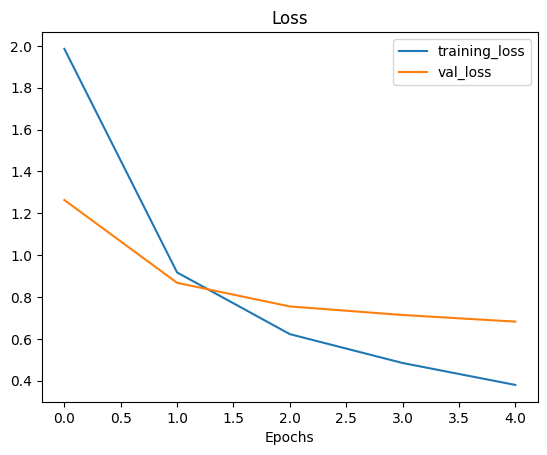

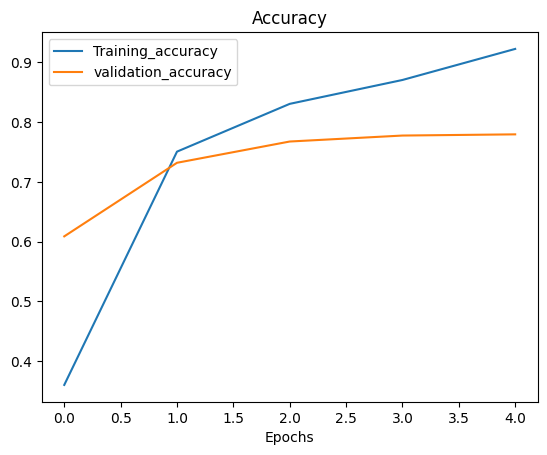

In [21]:
loss_curve(restnet_history)

### Creating an testing EfficentNetB0 model:

In [22]:
# Creating the efficient model:

efficient_model = create_model(efficient_net_url,
                               num_classes = train_data_10.num_classes)

In [23]:
# Compile the model:
efficient_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [24]:
# Fit the model:

efficient_model_history = efficient_model.fit(train_data_10,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10),
                                              validation_data = test_data_10,
                                              validation_steps = len(test_data_10),
                                              callbacks = [tensorboard_callback(dir_name='tensorflow_hub',
                                                                                experiment_name = 'EfficientNetB0')])

Saving tensorboard log files to: tensorflow_hub/EfficientNetB0/20230522-164801%
Epoch 1/5
24/24 [==============================] - 33s 919ms/step - loss: 1.8832 - accuracy: 0.4240 - val_loss: 1.3098 - val_accuracy: 0.7384
Epoch 2/5
24/24 [==============================] - 18s 781ms/step - loss: 1.0780 - accuracy: 0.7773 - val_loss: 0.8692 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 17s 738ms/step - loss: 0.7627 - accuracy: 0.8333 - val_loss: 0.6983 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 17s 736ms/step - loss: 0.6126 - accuracy: 0.8600 - val_loss: 0.6124 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 18s 776ms/step - loss: 0.5177 - accuracy: 0.8800 - val_loss: 0.5620 - val_accuracy: 0.8592


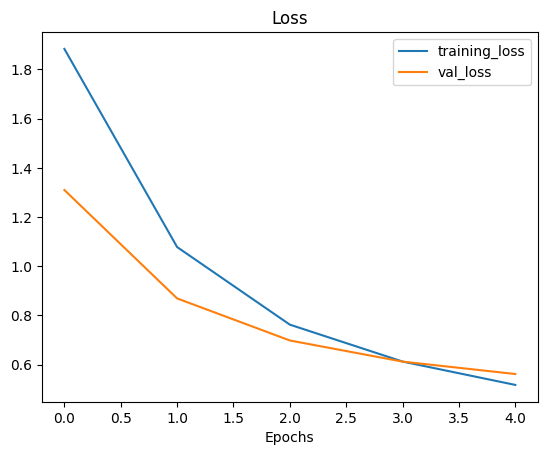

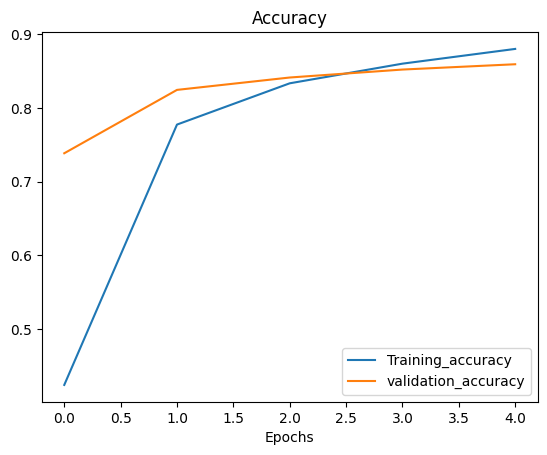

In [25]:
# Lets plot the loss_curves :

loss_curve(efficient_model_history)

In [26]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [27]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Comparing ResNet and EfficientNetB0, 

* EfficientNetB0 is having very good accuracy compared to ResNet.
* Also loss_curves show that EfficientNet is not so overfitting and loss and accuracy trend in the training and validation.

## Comparing our models results using Tensorboard:

In [28]:
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs ResNet50V2'\
  --description 'Comparing two different Tfhub feature Extraction model using only 10% of data'\
  --one_shot

2023-05-22 17:21:17.292525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   JPDR-HFMQ



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

Our Tensorboard experiments are uploaded publically here :
https://tensorboard.dev/experiment/Ki1uNYNjR9Kt3DTVENirLg/

In [29]:
!tensorboard dev list

2023-05-22 17:28:40.481663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/Ki1uNYNjR9Kt3DTVENirLg/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different Tfhub feature Extraction model using only 10% of data
	Id                   Ki1uNYNjR9Kt3DTVENirLg
	Created              2023-05-22 17:22:13 (6 minutes ago)
	Updated              2023-05-22 17:22:17 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
Total: 1 experiment(s)


This will list all the experiments